In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import ensemble
import sklearn.model_selection as ms
from sklearn import metrics
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import os
import math as m
from matplotlib.colors import LogNorm
import collections
import pickle
import itertools

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
N_THREADS = 88
os.environ['OMP_NUM_THREADS'] = str(N_THREADS)
tf.config.threading.set_intra_op_parallelism_threads(int(N_THREADS/2))
tf.config.threading.set_inter_op_parallelism_threads(int(N_THREADS/2))
print(tf.__version__)
sns.set(font_scale=1., style='white')
seed = 42

2.2.0


## Load the Data and train the model

In [2]:
def fileparser(path, dlist, frac=0.5, sample=0):
    df = pd.read_csv(path)
    df.drop(columns=dlist, inplace=True)    
    n = len(df)
    weight = int(round(np.abs(df['weight'].sum()) * 3. * 1e6)) ## The abs(mean()) is taken to make the weight of ybyt +ve
    df['weight'] = df['weight']/np.abs(df['weight'])
    if sample != 0:
        df_train = df.sample(n=sample, random_state=seed)
        df_test = df.drop(df_train.index)
    else :
        df_test = df.sample(frac=frac, random_state=seed)
        df_train = df.drop(df_test.index)
    return df_train, df_test, weight

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(np.log(cm), interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [29]:
dlist = ['dphibb', 'etaaa', 'ptb2', 'drbamin', 'met', 'etaa2', 'etab1', 'etaa1', 'nbjet', 'etab2']

# 13 TeV
# df_yb2_7, df_yb2_test_7, weight_yb2_7 = fileparser("ROOT/gencut_set7/yb2.csv", dlist, sample=10000)
# df_yb2_6, df_yb2_test_6, weight_yb2_6 = fileparser("ROOT/gencut_set6/yb2.csv", dlist, sample=5000)
# df_yb2_5, df_yb2_test_5, weight_yb2_5 = fileparser("ROOT/gencut_set5/yb2.csv", dlist, sample=5000)
# df_yb2 = pd.concat([df_yb2_7, df_yb2_6, df_yb2_5])
# df_yb2_test = pd.concat([df_yb2_test_7, df_yb2_test_6, df_yb2_test_5])
# weight_yb2 = int(np.max([weight_yb2_7, weight_yb2_6, weight_yb2_5]))

# df_ybyt_7, df_ybyt_test_7, weight_ybyt_7 = fileparser("ROOT/gencut_set7/ybyt.csv", dlist, sample=10000)
# df_ybyt_6, df_ybyt_test_6, weight_ybyt_6 = fileparser("ROOT/gencut_set6/ybyt.csv", dlist, sample=5000)
# df_ybyt_5, df_ybyt_test_5, weight_ybyt_5 = fileparser("ROOT/gencut_set5/ybyt.csv", dlist, sample=5000)
# df_ybyt = pd.concat([df_ybyt_7, df_ybyt_6, df_ybyt_5])
# df_ybyt_test = pd.concat([df_ybyt_test_7, df_ybyt_test_6, df_ybyt_test_5])
# weight_ybyt = int(np.max([weight_ybyt_7, weight_ybyt_6, weight_ybyt_5]))

# df_yt2_7, df_yt2_test_7, weight_yt2_7 = fileparser("ROOT/gencut_set7/yt2.csv", dlist, sample=10000)
# df_yt2_6, df_yt2_test_6, weight_yt2_6 = fileparser("ROOT/gencut_set6/yt2.csv", dlist, sample=5000)
# df_yt2_5, df_yt2_test_5, weight_yt2_5 = fileparser("ROOT/gencut_set5/yt2.csv", dlist, sample=5000)
# df_yt2 = pd.concat([df_yt2_7, df_yt2_6, df_yt2_5])
# df_yt2_test = pd.concat([df_yt2_test_7, df_yt2_test_6, df_yt2_test_5])
# weight_yt2 = int(np.max([weight_yt2_7, weight_yt2_6, weight_yt2_5]))

# df_zh_7, df_zh_test_7, weight_zh_7 = fileparser("ROOT/gencut_set7/zh.csv", dlist, sample=20000)
# df_zh_5, df_zh_test_5, weight_zh_5 = fileparser("ROOT/gencut_set5/zh.csv", dlist, sample=20000)
# df_zh = pd.concat([df_zh_7, df_zh_5])
# df_zh_test = pd.concat([df_zh_test_7, df_zh_test_5])
# weight_zh = int(np.max([weight_zh_7, weight_zh_5]))

# df_bbxaa_7, df_bbxaa_test_7, weight_bbxaa_7 = fileparser("ROOT/gencut_set7/bbxaa.csv", dlist, frac=0.25, sample=50000)
# df_bbxaa_5, df_bbxaa_test_5, weight_bbxaa_5 = fileparser("ROOT/gencut_set5/bbxaa.csv", dlist, frac=0.25, sample=50000)
# df_bbxaa = pd.concat([df_bbxaa_7, df_bbxaa_5])
# df_bbxaa_test = pd.concat([df_bbxaa_test_7, df_bbxaa_test_5])
# weight_bbxaa = int(np.max([weight_bbxaa_7, weight_bbxaa_5]))

# 14 TeV
df_yb2, df_yb2_test, weight_yb2 = fileparser("ROOT/gencut_set9/yb2.csv", dlist, sample=20000)
df_ybyt, df_ybyt_test, weight_ybyt = fileparser("ROOT/gencut_set9/ybyt.csv", dlist, sample=20000)
df_yt2, df_yt2_test, weight_yt2 = fileparser("ROOT/gencut_set9/yt2.csv", dlist, sample=20000)
df_zh, df_zh_test, weight_zh = fileparser("ROOT/gencut_set9/zh.csv", dlist, sample=40000)
df_bbxaa, df_bbxaa_test, weight_bbxaa = fileparser("ROOT/gencut_set9/bbxaa.csv", dlist, sample=100000)

print("No. of yb2 events: train = {}, test = {}".format(df_yb2.shape[0],df_yb2_test.shape[0]))
print("No. of ybyt events: train = {}, test = {}".format(df_ybyt.shape[0],df_ybyt_test.shape[0]))
print("No. of yt2 events: train = {}, test = {}".format(df_yt2.shape[0],df_yt2_test.shape[0]))
print("No. of zh events: train = {}, test = {}".format(df_zh.shape[0],df_zh_test.shape[0]))
print("No. of bbxaa events: train = {}, test = {}".format(df_bbxaa.shape[0],df_bbxaa_test.shape[0]))

channels = [df_yb2, df_ybyt, df_yt2, df_zh, df_bbxaa]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

# Special treatment for ybyt
df_tmp = pd.read_csv("ROOT/gencut_set9/ybyt.csv")
ybyt_ratio = df_tmp[df_tmp['weight']<0].shape[0]/df_tmp[df_tmp['weight']>0].shape[0]

No. of yb2 events: train = 20000, test = 26740
No. of ybyt events: train = 20000, test = 18341
No. of yt2 events: train = 20000, test = 81774
No. of zh events: train = 40000, test = 139021
No. of bbxaa events: train = 100000, test = 37488


In [12]:
def runBDT(df, rf=False, depth=30, sample=1):
    mshap = True if depth <= 10 else False
    df = df.sample(frac=sample)
    X = df.drop(columns=['class', 'weight'])
    y = df['class'].values

    """ Split for training and testing
    """
    x_train, x_test, y_train, y_test = ms.train_test_split(X.values, y, test_size=0.2)
    eval_set = [(x_train, y_train), (x_test, y_test)]
    """ Fit the decision tree
    """
    if rf: 
        classifier = ensemble.RandomForestClassifier(max_depth=depth, n_estimators=1000, criterion='gini', n_jobs=int(N_THREADS/2))
        classifier = classifier.fit(x_train, y_train)
    else: 
        classifier = xgb.XGBClassifier(max_depth=depth, learning_rate=0.01, objective='multi:softprob', num_class=nchannels,
                                         nthread=N_THREADS, subsample=0.5, colsample_bytree=1, n_estimators=5000)
        classifier = classifier.fit(x_train, y_train, early_stopping_rounds=50, eval_set=eval_set,
                                eval_metric=["merror", "mlogloss"], verbose=False)
    
    """ Predictions
    """
    y_pred = classifier.predict(x_test)
    print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(y_test, y_pred)))
    pickle.dump(classifier, open('models/HL-LHC-BDT/hbb-BDT-multiclass-bg-1b-met-ht-btag.pickle.dat', 'wb'))
    
    class_names=[r'$bb\gamma\gamma$', r'$Zh$', r'$y_t^2$', r'$y_by_t$', r'$y_b^2$']
    if mshap:
        X_shap = pd.DataFrame(x_test, columns=df.drop(columns=['class', 'weight']).columns)
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_shap)
        shap.summary_plot(shap_values, X_shap, plot_type='bar', class_names=class_names, class_inds='original', plot_size=(9,6), show=False)
        ax = plt.gca()
        ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
        vals = ax.get_xticks()
        ax.tick_params(labelsize=14)
        for tick in vals:
            ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#808080', zorder=1)
        plt.tight_layout()
        plt.savefig('../plots/HL-LHC/shap-5.pdf')
    return classifier, x_test, y_test

def eval_training(classifier):
    results = classifier.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)

    # plot log loss
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x_axis, results['validation_0']['mlogloss'], label='train')
    plt.plot(x_axis, results['validation_1']['mlogloss'], label='test')
    plt.legend()

    plt.ylabel('log loss')
    plt.title('Classifier log loss')
    plt.grid()

    # plot classification error
    plt.subplot(1, 2, 2)
    plt.plot(x_axis, results['validation_0']['merror'], label='train')
    plt.plot(x_axis, results['validation_1']['merror'], label='test')
    plt.legend()

    plt.ylabel('Classification Error')
    plt.title('Classification Error')
    plt.grid()
    plt.show()

Accuracy Score: 64.55% 


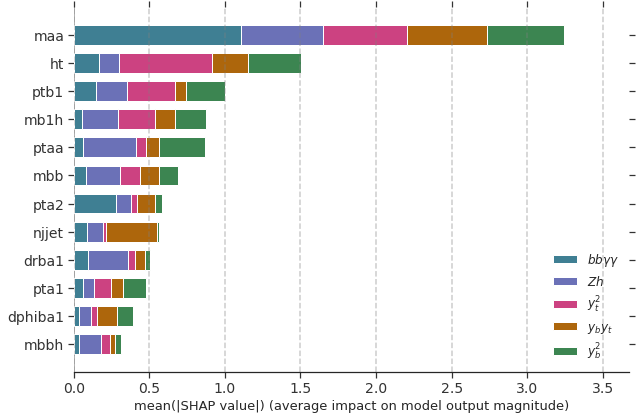

In [13]:
classifier, x_test, y_test = runBDT(df_train, rf=False, depth=10, sample=1)

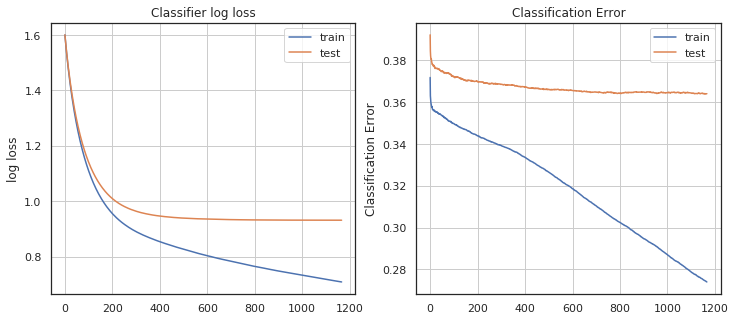

In [7]:
eval_training(classifier)

## Load the model here and run the rest.


In [5]:
classifier = pickle.load(open('models/HL-LHC-BDT/hbb-BDT-multiclass-bg-1b-met-ht-btag.pickle.dat', 'rb'))

In [6]:
comb_test = pd.concat([df_yb2_test.iloc[:,:-1], df_ybyt_test.iloc[:,:-1], df_yt2_test.iloc[:,:-1], df_zh_test.iloc[:,:-1], df_bbxaa_test.iloc[:,:-1]]).sample(frac=0.1, random_state=seed)
print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(comb_test['class'].values, classifier.predict(comb_test.drop(columns=['class']).values))))

Accuracy Score: 50.75% 


Accuracy Score for yb2: 28.25% 
Accuracy Score for ybyt: 21.19% 
Accuracy Score for yt2: 25.65% 
Accuracy Score for zh: 63.85% 
Accuracy Score for bbxaa: 87.73% 


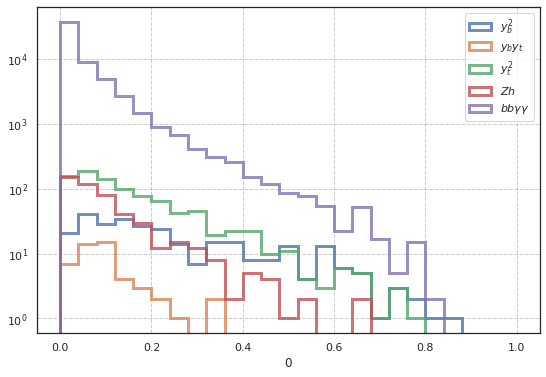

In [7]:
disc = 4
yb2_p = pd.DataFrame(classifier.predict_proba(df_yb2_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for yb2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yb2_test['class'].values, classifier.predict(df_yb2_test.drop(columns=['class', 'weight']).values))))
yb2_p['weight'] = df_yb2_test['weight'].values

ybyt_p = pd.DataFrame(classifier.predict_proba(df_ybyt_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for ybyt: {:4.2f}% '.format(100*metrics.accuracy_score(df_ybyt_test['class'].values, classifier.predict(df_ybyt_test.drop(columns=['class', 'weight']).values))))
ybyt_p['weight'] = df_ybyt_test['weight'].values

yt2_p = pd.DataFrame(classifier.predict_proba(df_yt2_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for yt2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yt2_test['class'].values, classifier.predict(df_yt2_test.drop(columns=['class', 'weight']).values))))
yt2_p['weight'] = df_yt2_test['weight'].values

zh_p = pd.DataFrame(classifier.predict_proba(df_zh_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for zh: {:4.2f}% '.format(100*metrics.accuracy_score(df_zh_test['class'].values, classifier.predict(df_zh_test.drop(columns=['class', 'weight']).values))))
zh_p['weight'] = df_zh_test['weight'].values

bbxaa_p = pd.DataFrame(classifier.predict_proba(df_bbxaa_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(df_bbxaa_test['class'].values, classifier.predict(df_bbxaa_test.drop(columns=['class', 'weight']).values))))
bbxaa_p['weight'] = df_bbxaa_test['weight'].values

yb2_pred = yb2_p.sample(n=round(weight_yb2*1.5), replace=True).reset_index(drop=True)
ybyt_pred = ybyt_p.sample(n=round(weight_ybyt*1.9), replace=True).reset_index(drop=True)
yt2_pred = yt2_p.sample(n=round(weight_yt2*2.5), replace=True).reset_index(drop=True)
zh_pred = zh_p.sample(n=round(weight_zh*1.93), replace=True).reset_index(drop=True)
bbxaa_pred = bbxaa_p.sample(n=round(weight_bbxaa*1.5), replace=True).reset_index(drop=True)

plt.figure(figsize=(9,6))
sns.distplot(yb2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_b^2$')
sns.distplot(ybyt_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_by_t$')
sns.distplot(yt2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_t^2$')
sns.distplot(zh_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$Zh$')
sns.distplot(bbxaa_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$bb\gamma\gamma$')
plt.legend()
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.yscale('log')

In [8]:
def get_mclass(i, df_array, weight_array, ps_exp_class, seed=seed):
    mclass = []
    for j in range(nchannels):
        mclass.append(collections.Counter(classifier.predict(df_array[j].iloc[:,:-2].values))[i]/len(df_array[j])*weight_array[j]/weight_array[i])

    sig = np.sqrt(ps_exp_class[i])*mclass[i]/np.sum(mclass)
    nevents = np.round(ps_exp_class[i]/np.sum(mclass)*np.array(mclass)).astype(int)
    print('sig: {:2.2f}, yb2 events: {}, ybyt events: {}, yt2 events: {}, zh events: {}, bbxaa events: {}'.format(sig, nevents[4], nevents[3], nevents[2], nevents[1], nevents[0]))
    return nevents, sig  

In [26]:
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.93, weight_yt2*2.5, weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

# weight_array = [weight_bbxaa*1.5, weight_zh*1.93, weight_yt2*2.5, weight_ybyt*1.9, weight_yb2*1.5]

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion = np.column_stack((nevents_bbxaa, nevents_zh, nevents_yt2, nevents_ybyt, nevents_yb2))

sig: 2.32, yb2 events: 85, ybyt events: 3, yt2 events: 118, zh events: 16, bbxaa events: 1103
sig: 0.27, yb2 events: 28, ybyt events: 10, yt2 events: 57, zh events: 21, bbxaa events: 1239
sig: 7.22, yb2 events: 26, ybyt events: 2, yt2 events: 231, zh events: 16, bbxaa events: 746
sig: 4.44, yb2 events: 59, ybyt events: 12, yt2 events: 264, zh events: 302, bbxaa events: 3975
sig: 224.43, yb2 events: 95, ybyt events: 21, yt2 events: 245, zh events: 119, bbxaa events: 50843


In [40]:
df_ybyt_test_pos = df_ybyt_test[df_ybyt_test['weight']==1]
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test_pos, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.93, weight_yt2*2.5, (1./(ybyt_ratio-1.))*weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class_pos = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion_pos = np.column_stack((nevents_bbxaa, nevents_zh, nevents_yt2, nevents_ybyt, nevents_yb2))

sig: 2.33, yb2 events: 85, ybyt events: 1, yt2 events: 118, zh events: 16, bbxaa events: 1104
sig: 0.14, yb2 events: 28, ybyt events: 5, yt2 events: 58, zh events: 21, bbxaa events: 1243
sig: 7.22, yb2 events: 26, ybyt events: 1, yt2 events: 231, zh events: 17, bbxaa events: 746
sig: 4.44, yb2 events: 59, ybyt events: 9, yt2 events: 264, zh events: 302, bbxaa events: 3978
sig: 224.46, yb2 events: 95, ybyt events: 13, yt2 events: 245, zh events: 119, bbxaa events: 50850


In [41]:
df_ybyt_test_neg = df_ybyt_test[df_ybyt_test['weight']==-1]
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test_neg, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.93, weight_yt2*2.5, (ybyt_ratio/(ybyt_ratio-1.))*weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class_pos = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion_neg = np.column_stack((nevents_bbxaa, nevents_zh, nevents_yt2, nevents_ybyt, nevents_yb2))

sig: 2.32, yb2 events: 84, ybyt events: 5, yt2 events: 117, zh events: 16, bbxaa events: 1101
sig: 0.47, yb2 events: 28, ybyt events: 17, yt2 events: 57, zh events: 21, bbxaa events: 1232
sig: 7.21, yb2 events: 26, ybyt events: 3, yt2 events: 230, zh events: 16, bbxaa events: 745
sig: 4.44, yb2 events: 59, ybyt events: 18, yt2 events: 264, zh events: 301, bbxaa events: 3970
sig: 224.37, yb2 events: 95, ybyt events: 33, yt2 events: 245, zh events: 119, bbxaa events: 50831


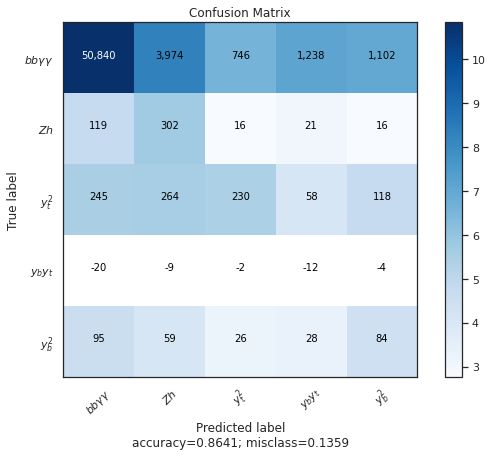

In [53]:
confusion_tot = np.round(np.array([confusion_pos[0]*0.5, confusion_pos[1]*0.5, confusion_pos[2]*0.5, confusion_pos[3], confusion_pos[4]*0.5])
        +np.array([confusion_neg[0]*0.5, confusion_neg[1]*0.5, confusion_neg[2]*0.5, -confusion_neg[3], confusion_neg[4]*0.5])).astype(int)

plot_confusion_matrix(cm           = confusion_tot, 
                      normalize    = False,
                      target_names = [r'$bb\gamma\gamma$', r'$Zh$', r'$y_t^2$', r'$y_by_t$', r'$y_b^2$'],
                      title        = "Confusion Matrix")

In [134]:
confusion_tot_tmp = confusion_tot
event_total = np.array([[np.sum(confusion_tot[i])] for i in range(confusion_tot.shape[0])])
significance = np.array([np.abs(confusion_tot[i,i])/np.sqrt(np.sum(confusion_tot[:,i])) for i in range(confusion_tot.shape[0])])
significance = np.append(significance, 0)
confusion_tab1 = np.append(confusion_tot_tmp, event_total, axis=1)
confusion_tab2 = np.vstack((confusion_tab1, significance))
    
df_conf = pd.DataFrame(confusion_tab2, [r'$bb\gamma\gamma$', r'$Zh$', r'$y_t^2$', r'$y_by_t$', r'$y_b^2$', r'$\sigma$'])
df_conf.columns = [r'$bb\gamma\gamma$', r'$Zh$', r'$y_t^2$', r'$y_by_t$', r'$y_b^2$', 'total']
print(df_conf.to_latex(escape=False))

\begin{tabular}{lrrrrrr}
\toprule
{} &  $bb\gamma\gamma$ &         $Zh$ &     $y_t^2$ &     $y_by_t$ &      $y_b^2$ &    total \\
\midrule
$bb\gamma\gamma$ &       50840.00000 &  3974.000000 &  746.000000 &  1238.000000 &  1102.000000 &  57900.0 \\
$Zh$             &         119.00000 &   302.000000 &   16.000000 &    21.000000 &    16.000000 &    474.0 \\
$y_t^2$          &         245.00000 &   264.000000 &  230.000000 &    58.000000 &   118.000000 &    915.0 \\
$y_by_t$         &         -20.00000 &    -9.000000 &   -2.000000 &   -12.000000 &    -4.000000 &    -47.0 \\
$y_b^2$          &          95.00000 &    59.000000 &   26.000000 &    28.000000 &    84.000000 &    292.0 \\
$\sigma$         &         224.51004 &     4.457595 &    7.215742 &     0.328675 &     2.315535 &      0.0 \\
\bottomrule
\end{tabular}



In [49]:
sig = 0
sig2 = 0
bdt_n_yb2 = 0
bdt_n_ybyt = 0
bdt_n_yt2 = 0
bdt_n_zh = 0
bdt_n_bbxaa = 0
N = 400
for i in range(N):
    yb2_pred = yb2_p.sample(n=round(weight_yb2*1.5), replace=True).reset_index(drop=True)
    ybyt_pred = ybyt_p.sample(n=round(weight_ybyt*1.9), replace=True).reset_index(drop=True)
    yt2_pred = yt2_p.sample(n=round(weight_yt2*2.5), replace=True).reset_index(drop=True)
    zh_pred = zh_p.sample(n=round(weight_zh*1.93), replace=True).reset_index(drop=True)
    bbxaa_pred = bbxaa_p.sample(n=round(weight_bbxaa*1.5), replace=True).reset_index(drop=True)
    
    cut = 0.5
    bdt_tmp_yb2 = yb2_pred.loc[yb2_pred[0] >= cut]['weight'].sum()
    bdt_tmp_ybyt = ybyt_pred.loc[ybyt_pred[0] >= cut]['weight'].sum()
    bdt_tmp_yt2 = yt2_pred.loc[yt2_pred[0] >= cut]['weight'].sum()
    bdt_tmp_zh = zh_pred.loc[zh_pred[0] >= cut]['weight'].sum()
    bdt_tmp_bbxaa = bbxaa_pred.loc[bbxaa_pred[0] >= cut]['weight'].sum()
    
    bdt_n_yb2 = int(bdt_n_yb2 + bdt_tmp_yb2)
    bdt_n_ybyt = int(bdt_n_ybyt + bdt_tmp_ybyt)
    bdt_n_yt2 = int(bdt_n_yt2 + bdt_tmp_yt2)
    bdt_n_zh = int(bdt_n_zh + bdt_tmp_zh)
    bdt_n_bbxaa = int(bdt_n_bbxaa + bdt_tmp_bbxaa)
    
    ss = (bdt_tmp_yb2)/m.sqrt(bdt_tmp_yb2 + bdt_tmp_ybyt + bdt_tmp_yt2 + bdt_tmp_zh + bdt_tmp_bbxaa)
    sig = sig + ss
    sig2 = sig2 + ss*ss
    
sig = sig/N
sig2 = m.sqrt(sig2/N - sig*sig)
bdt_n_yb2 = int(bdt_n_yb2/N)
bdt_n_ybyt = int(bdt_n_ybyt/N)
bdt_n_yt2 = int(bdt_n_yt2/N)
bdt_n_zh = int(bdt_n_zh/N)
bdt_n_bbxaa = int(bdt_n_bbxaa/N)
print(bdt_n_yb2, "yb2-like events.", bdt_n_ybyt, "ybyt-like event.", bdt_n_yt2,
      "yt2-like event.", bdt_n_zh, "zh-like event.", bdt_n_bbxaa, "bxaa event.")
print("sig/sqrt(sig+bkg): {:2.2f} +/- {:2.2f}".format(sig, sig2))

38 yb2-like events. 0 ybyt-like event. 37 yt2-like event. 2 zh-like event. 249 bxaa event.
sig/sqrt(sig+bkg): 2.11 +/- 0.29


In [13]:
class PrintDots(Callback):
    """ Print dots to monitor the progress of the fit
    """
    def on_epoch_end(self, epoch, logs):
        logs = logs or {}
        value = logs.get('val_loss')
        if epoch % 50 == 0:
            print(' epochs = ', epoch, ' val_loss = ', value)
        print('*', end='')

class TerminateOnBaseline(Callback):
    """ Callback that terminates training when monitored value reaches a specified baseline
    """
    def __init__(self, monitor='val_loss', patience=200):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = np.Inf
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        value = logs.get(self.monitor)
        if epoch == 0:
            self.baseline = value/100.
        if np.less(value, self.best):
            self.best = value
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
        if value is not None:
            if value <= self.baseline and self.wait >= self.patience:
                self.stopped_epoch = epoch
                print('\nepoch %d: Reached baseline, terminating training and lost patience' % epoch)
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch.')
                self.model.set_weights(self.best_weights)
            elif self.wait >= self.patience:
                self.baseline *= 2.5
                self.wait = self.patience/2
                print('\nbaseline increased since learning times is approaching death')
                
def plot_history(history):
    """ Plots to track the history of the metrics
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('accuracy [y]')
    plt.plot(hist['epoch'], hist['accuracy'], label='train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='val accuracy')
    plt.ylim([0.5, 0.7])
    plt.legend()
    plt.show()

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val loss')
    plt.ylim([0.8, 1])
    plt.legend()
    plt.show()
    

In [14]:
def build_model(df):
    """ Build the model, define the optimizer and compile the model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=[len(df.keys())-1]),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [15]:
model = build_model(df_yb2)
model.summary()    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                208       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 85        
Total params: 1,381
Trainable params: 1,381
Non-trainable params: 0
______________________________________________________

In [16]:
# learning_rate = 0.003
EPOCHS = 200000
patience = 50
df_train_set = df_train.copy(deep=True)
df_train_labels = df_train_set.pop('class')

""" Extract the history of the fit
"""
history = model.fit(
    df_train_set, df_train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size=320,
    callbacks=[TerminateOnBaseline(monitor='val_loss', patience=patience), PrintDots()])

""" Extract the history and make some plots
"""
print("\n", "Epochs = ", history.epoch[-1])

loss, accuracy = model.evaluate(df_yb2_test.iloc[:,:-1], df_yb2_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for yb2: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_ybyt_test.iloc[:,:-1], df_ybyt_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for ybyt: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_yt2_test.iloc[:,:-1], df_yt2_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for yt2: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_zh_test.iloc[:,:-1], df_zh_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for zh: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_bbxaa_test.iloc[:,:-1], df_bbxaa_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for bbxaa: {:4.2f}%".format(accuracy*100))

 epochs =  0  val_loss =  1.2525292918977908
************************************************** epochs =  50  val_loss =  1.1654856785031922
************************************************** epochs =  100  val_loss =  1.0294376413494792
************************************************** epochs =  150  val_loss =  1.0254724006869207
************************************************** epochs =  200  val_loss =  1.022506288685311
************************************************** epochs =  250  val_loss =  1.0206111007887233
************************************************** epochs =  300  val_loss =  1.0187107741296395
************************************************** epochs =  350  val_loss =  1.0251862647548282
******
baseline increased since learning times is approaching death
*************************
baseline increased since learning times is approaching death
******************* epochs =  400  val_loss =  1.0217633145820075
******
baseline increased since learning times is approac

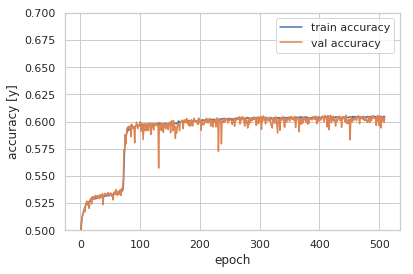

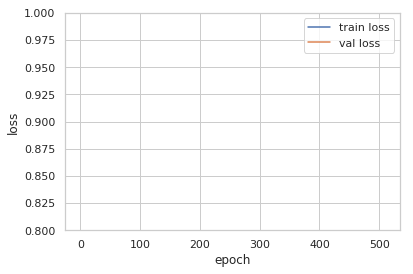

In [17]:
plot_history(history)

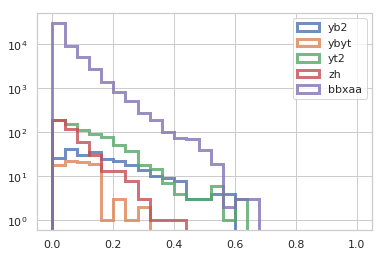

In [18]:
disc = 4
test_predictions_yb2 = model.predict(df_yb2_test.sample(n=round(weight_yb2*1.5), replace=True).reset_index(drop=True).iloc[:,:-1])[:,disc]
test_predictions_ybyt = model.predict(df_ybyt_test.sample(n=round(weight_ybyt*1.9), replace=True).reset_index(drop=True).iloc[:,:-1])[:,disc]
test_predictions_yt2 = model.predict(df_yt2_test.sample(n=round(weight_yt2*2.5), replace=True).reset_index(drop=True).iloc[:,:-1])[:,disc]
test_predictions_zh = model.predict(df_zh_test.sample(n=round(weight_zh*1.93), replace=True).reset_index(drop=True).iloc[:,:-1])[:,disc]
test_predictions_bbxaa = model.predict(df_bbxaa_test.sample(n=round(weight_bbxaa*1.5), replace=True).reset_index(drop=True).iloc[:,:-1])[:,disc]


plt.figure()
plt.hist(test_predictions_yb2, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3, label='yb2')
plt.hist(test_predictions_ybyt, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3, label='ybyt')
plt.hist(test_predictions_yt2, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3, label='yt2')
plt.hist(test_predictions_zh, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3, label='zh')
plt.hist(test_predictions_bbxaa, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3, label='bbxaa')
plt.legend()
plt.yscale('log')

In [19]:
cut = 0.5
NN_n_yb2 = len(np.where(test_predictions_yb2 > cut)[0])
NN_n_ybyt = len(np.where(test_predictions_ybyt > cut)[0])
NN_n_yt2 = len(np.where(test_predictions_yt2 > cut)[0])
NN_n_zh = len(np.where(test_predictions_zh > cut)[0])
NN_n_bbxaa = len(np.where(test_predictions_bbxaa > cut)[0])
print(NN_n_yb2, "yb2-like events.", NN_n_ybyt, "ybyt-like event.", NN_n_yt2, "yt2-like event.",
      NN_n_zh, "zh-like event.", NN_n_bbxaa, "bbxaa event.")
print("sig/sqrt(sig+bkg): ",NN_n_yb2/m.sqrt(NN_n_yb2 + NN_n_ybyt + NN_n_yt2 + NN_n_zh + NN_n_bbxaa))

10 yb2-like events. 0 ybyt-like event. 10 yt2-like event. 0 zh-like event. 50 bbxaa event.
sig/sqrt(sig+bkg):  1.1952286093343936


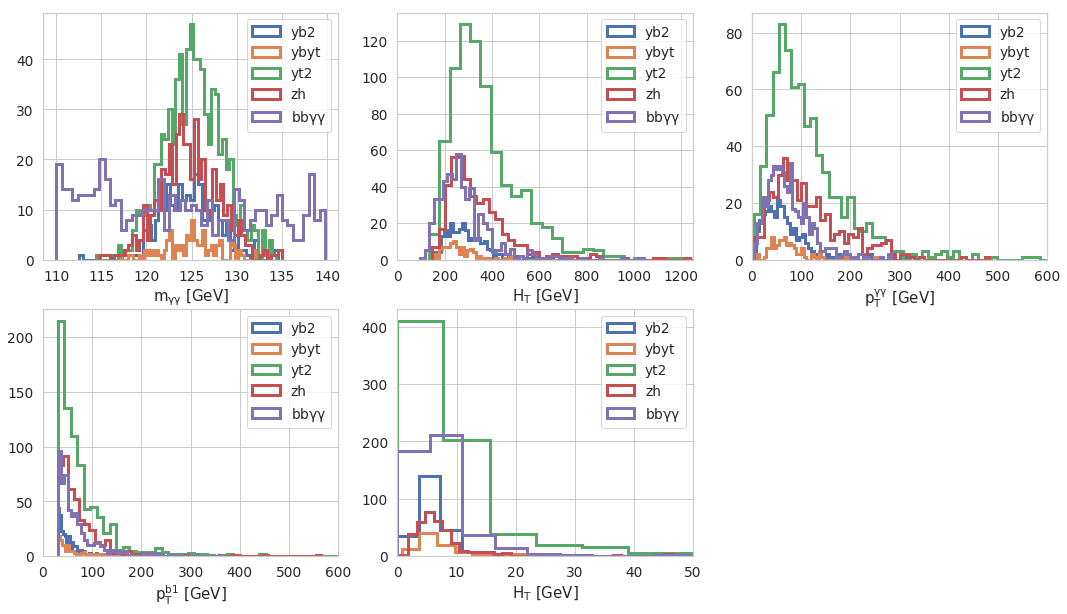

In [21]:
df_yb2_h = df_yb2.sample(n=round(weight_yb2*1.5), replace=True).reset_index(drop=True)

plt.figure(figsize=(18,10))
plt.subplot(2,3,1)
plt.hist(df_yb2.sample(n=round(weight_yb2*1.5), replace=True).maa, bins=50, histtype='step', linewidth=3, label='yb2')
plt.hist(df_ybyt.sample(n=round(weight_ybyt*1.9), replace=True).maa, bins=50, histtype='step', linewidth=3, label='ybyt')
plt.hist(df_yt2.sample(n=round(weight_yt2*2.5), replace=True).maa, bins=50, histtype='step', linewidth=3, label='yt2')
plt.hist(df_zh.sample(n=round(weight_zh*1.93), replace=True).maa, bins=50, histtype='step', linewidth=3, label='zh')
plt.hist(df_bbxaa.sample(n=round(weight_bbxaa*1.5/100.), replace=True).maa, bins=50, histtype='step', linewidth=3, label=r'$bb\gamma\gamma$')
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]')
plt.legend()

plt.subplot(2,3,2)
plt.hist(df_yb2.sample(n=round(weight_yb2*1.5), replace=True).ht, bins=50, histtype='step', linewidth=3, label='yb2')
plt.hist(df_ybyt.sample(n=round(weight_ybyt*1.9), replace=True).ht, bins=50, histtype='step', linewidth=3, label='ybyt')
plt.hist(df_yt2.sample(n=round(weight_yt2*2.5), replace=True).ht, bins=50, histtype='step', linewidth=3, label='yt2')
plt.hist(df_zh.sample(n=round(weight_zh*1.93), replace=True).ht, bins=50, histtype='step', linewidth=3, label='zh')
plt.hist(df_bbxaa.sample(n=round(weight_bbxaa*1.5/100.), replace=True).ht, bins=50, histtype='step', linewidth=3, label=r'$bb\gamma\gamma$')
plt.legend()
plt.xlabel(r'$H_{T}$ [GeV]')
plt.xlim(0,1250)

plt.subplot(2,3,3)
plt.hist(df_yb2.sample(n=round(weight_yb2*1.5), replace=True).ptaa, bins=50, histtype='step', linewidth=3, label='yb2')
plt.hist(df_ybyt.sample(n=round(weight_ybyt*1.9), replace=True).ptaa, bins=50, histtype='step', linewidth=3, label='ybyt')
plt.hist(df_yt2.sample(n=round(weight_yt2*2.5), replace=True).ptaa, bins=50, histtype='step', linewidth=3, label='yt2')
plt.hist(df_zh.sample(n=round(weight_zh*1.93), replace=True).ptaa, bins=50, histtype='step', linewidth=3, label='zh')
plt.hist(df_bbxaa.sample(n=round(weight_bbxaa*1.5/100.), replace=True).ptaa, bins=50, histtype='step', linewidth=3, label=r'$bb\gamma\gamma$')
plt.legend()
plt.xlabel(r'$p_{T}^{\gamma\gamma}$ [GeV]')
plt.xlim(0,600)

plt.subplot(2,3,4)
plt.hist(df_yb2.sample(n=round(weight_yb2*1.5), replace=True).ptb1, bins=50, histtype='step', linewidth=3, label='yb2')
plt.hist(df_ybyt.sample(n=round(weight_ybyt*1.9), replace=True).ptb1, bins=50, histtype='step', linewidth=3, label='ybyt')
plt.hist(df_yt2.sample(n=round(weight_yt2*2.5), replace=True).ptb1, bins=50, histtype='step', linewidth=3, label='yt2')
plt.hist(df_zh.sample(n=round(weight_zh*1.93), replace=True).ptb1, bins=50, histtype='step', linewidth=3, label='zh')
plt.hist(df_bbxaa.sample(n=round(weight_bbxaa*1.5/100.), replace=True).ptb1, bins=50, histtype='step', linewidth=3, label=r'$bb\gamma\gamma$')
plt.legend()
plt.xlabel(r'$p_{T}^{b1}$ [GeV]')
plt.xlim(0,600)

plt.subplot(2,3,5)
plt.hist(df_yb2.sample(n=round(weight_yb2*1.5), replace=True).mbb, bins=100, histtype='step', linewidth=3, label='yb2')
plt.hist(df_ybyt.sample(n=round(weight_ybyt*1.9), replace=True).mbb, bins=100, histtype='step', linewidth=3, label='ybyt')
plt.hist(df_yt2.sample(n=round(weight_yt2*2.5), replace=True).mbb, bins=100, histtype='step', linewidth=3, label='yt2')
plt.hist(df_zh.sample(n=round(weight_zh*1.93), replace=True).mbb, bins=100, histtype='step', linewidth=3, label='zh')
plt.hist(df_bbxaa.sample(n=round(weight_bbxaa*1.5/100.), replace=True).mbb, bins=100, histtype='step', linewidth=3, label=r'$bb\gamma\gamma$')
plt.legend()
plt.xlabel(r'$H_{T}$ [GeV]')
plt.xlim(0,50)


plt.show()

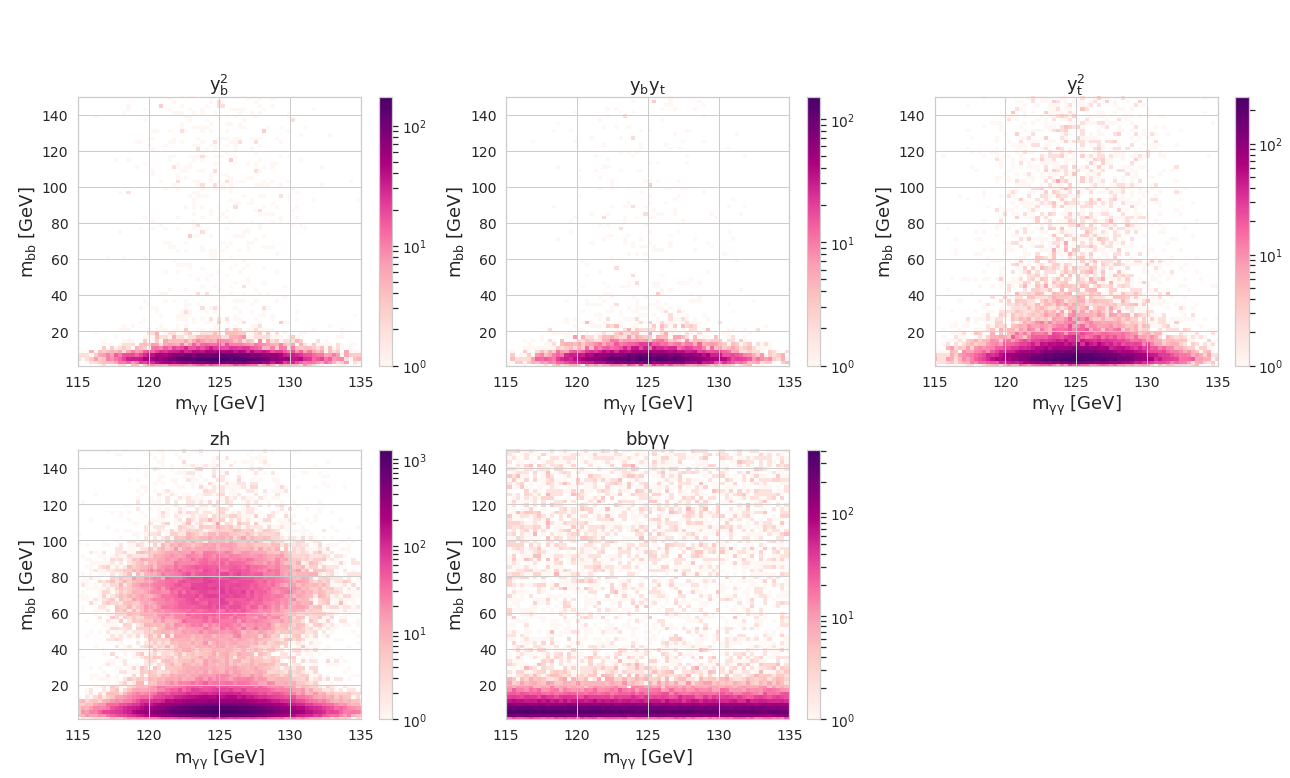

In [75]:
plt.figure(figsize=(18,10))
logs = False
plt.subplot(2,3,1)
plt.hist2d(df_yb2[df_yb2['mbb'] < 200].maa, df_yb2[df_yb2['mbb'] < 200].mbb, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$m_{bb}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,150)
plt.title(r'$y_b^2$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,2)
plt.hist2d(df_ybyt[df_ybyt['mbb'] < 200].maa, df_ybyt[df_ybyt['mbb'] < 200].mbb, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$m_{bb}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,150)
plt.title(r'$y_by_t$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,3)
plt.hist2d(df_yt2[df_yt2['mbb'] < 200].maa, df_yt2[df_yt2['mbb'] < 200].mbb, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$m_{bb}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,150)
plt.title(r'$y_t^2$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,4)
plt.hist2d(df_zh[df_zh['mbb'] < 200].maa, df_zh[df_zh['mbb'] < 200].mbb, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$m_{bb}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,150)
plt.title(r'$zh$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,5)
plt.hist2d(df_bbxaa[df_bbxaa['mbb'] < 200].maa, df_bbxaa[df_bbxaa['mbb'] < 200].mbb, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$m_{bb}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,150)
plt.title(r'$bb\gamma\gamma$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.tight_layout()
plt.show()

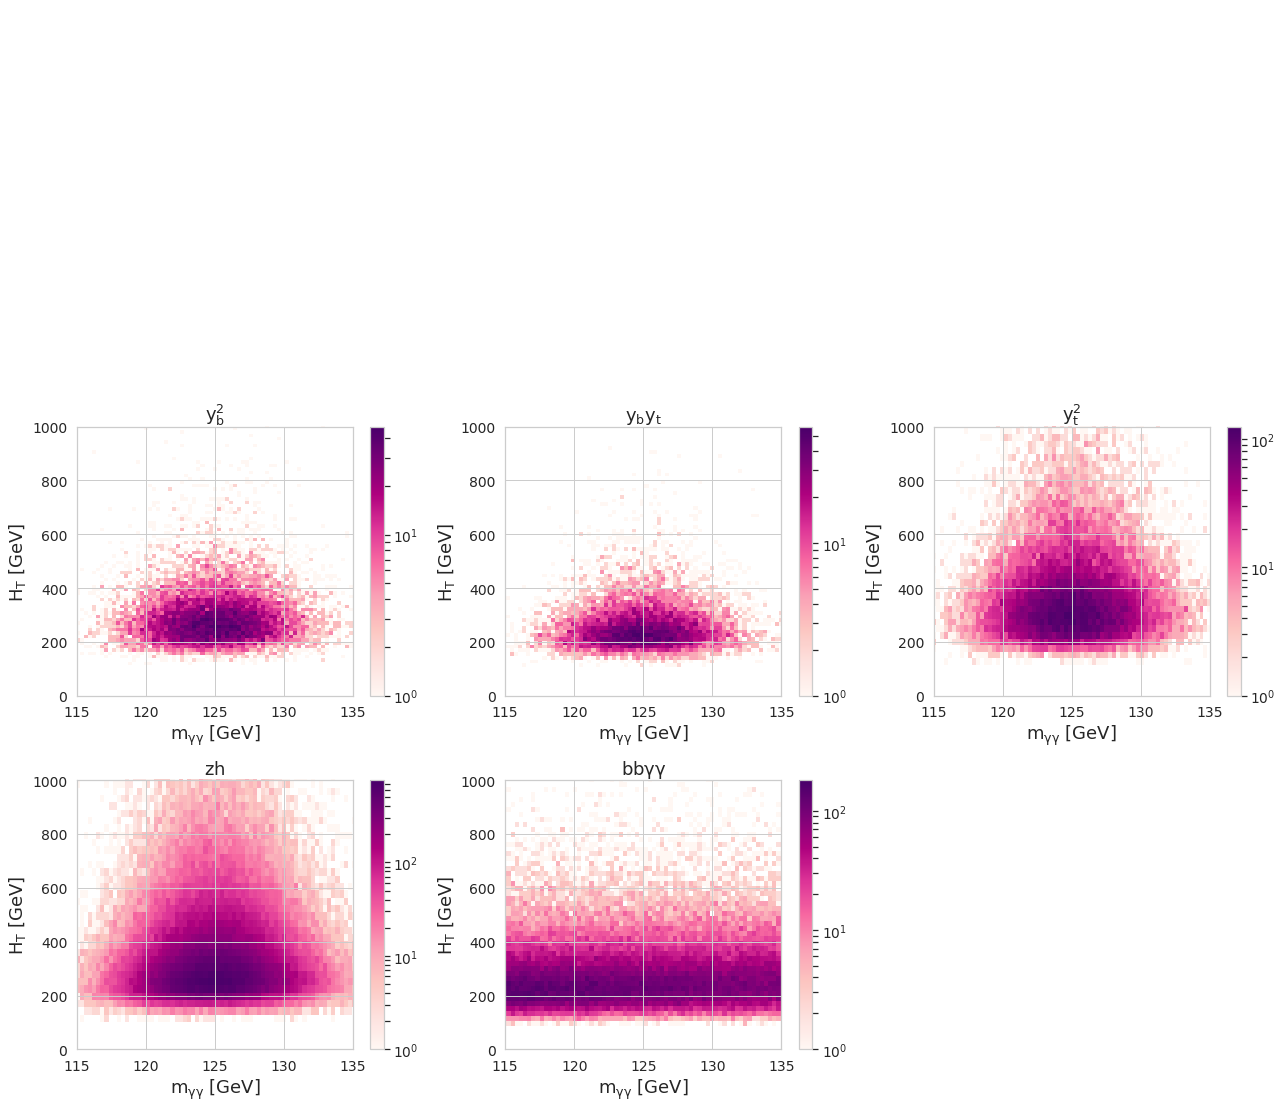

In [79]:
plt.figure(figsize=(18,10))
logs = False
plt.subplot(2,3,1)
plt.hist2d(df_yb2.maa, df_yb2.ht, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$H_{T}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,1000)
plt.title(r'$y_b^2$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,2)
plt.hist2d(df_ybyt.maa, df_ybyt.ht, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$H_{T}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,1000)
plt.title(r'$y_by_t$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,3)
plt.hist2d(df_yt2.maa, df_yt2.ht, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$H_{T}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,1000)
plt.title(r'$y_t^2$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,4)
plt.hist2d(df_zh.maa, df_zh.ht, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$H_{T}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,1000)
plt.title(r'$zh$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,5)
plt.hist2d(df_bbxaa.maa, df_bbxaa.ht, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$H_{T}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,1000)
plt.title(r'$bb\gamma\gamma$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.tight_layout()
plt.show()

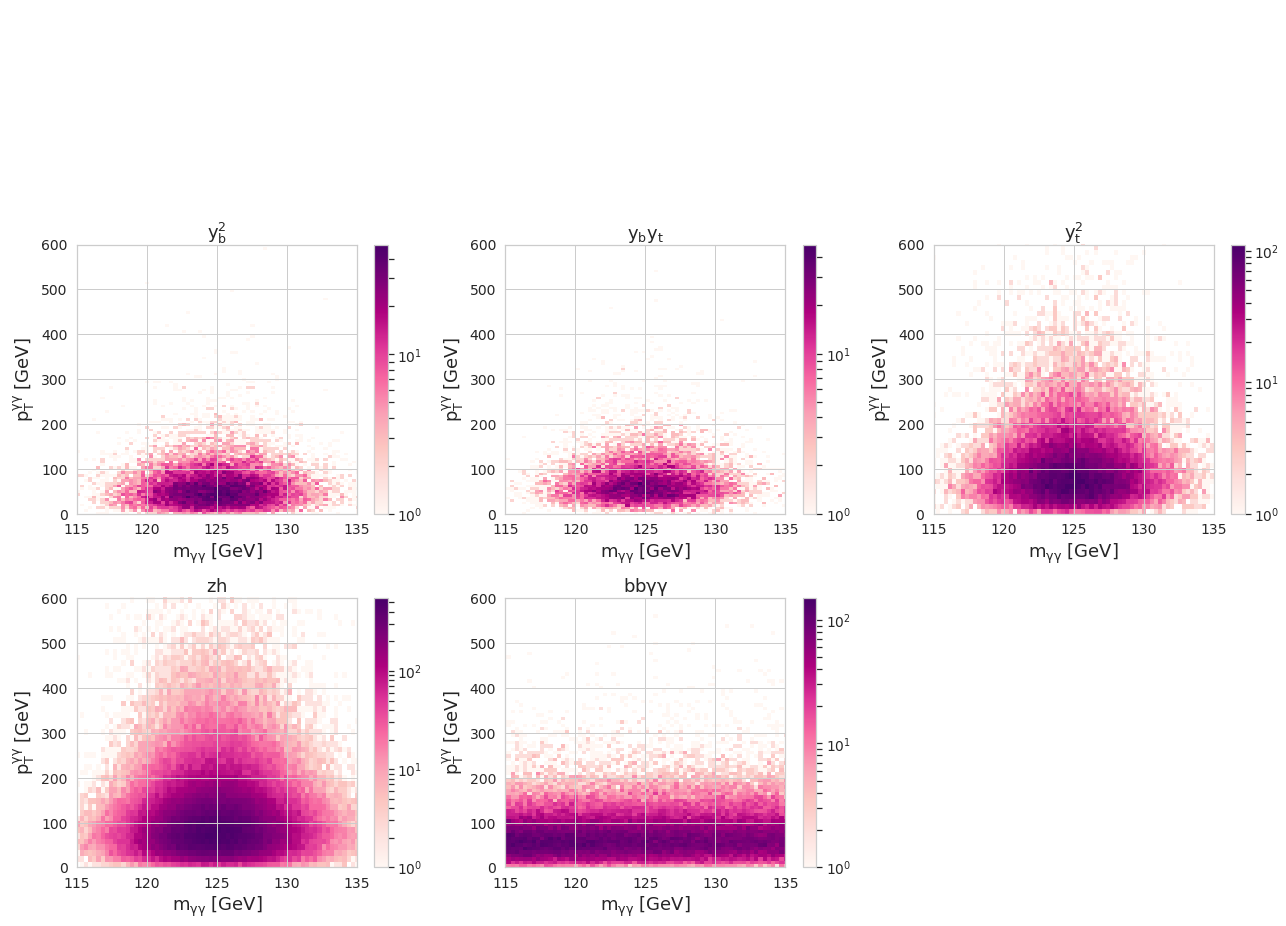

In [78]:
plt.figure(figsize=(18,10))
logs = False
plt.subplot(2,3,1)
plt.hist2d(df_yb2.maa, df_yb2.ptaa, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$p_{T}^{\gamma\gamma}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,600)
plt.title(r'$y_b^2$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,2)
plt.hist2d(df_ybyt.maa, df_ybyt.ptaa, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$p_{T}^{\gamma\gamma}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,600)
plt.title(r'$y_by_t$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,3)
plt.hist2d(df_yt2.maa, df_yt2.ptaa, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$p_{T}^{\gamma\gamma}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,600)
plt.title(r'$y_t^2$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,4)
plt.hist2d(df_zh.maa, df_zh.ptaa, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$p_{T}^{\gamma\gamma}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,600)
plt.title(r'$zh$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,5)
plt.hist2d(df_bbxaa.maa, df_bbxaa.ptaa, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{\gamma\gamma}$ [GeV]', fontsize=18)
plt.ylabel(r'$p_{T}^{\gamma\gamma}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,600)
plt.title(r'$bb\gamma\gamma$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.tight_layout()
plt.show()